In [1]:
#from pywps.Process import WPSProcess  
from types import FloatType
from lxml import etree
#import xml.etree.cElementTree as etree
import urllib2
import jdcal
import numpy as np
import cStringIO
from cStringIO import StringIO
import pandas as pd
import json
import datetime
import logging

def GetCoverageNames():
    file_json = r'D:\tmp//coverages_names.json'
    with open(file_json) as json_data:
        d = json.load(json_data)
    _CoverageID_NDVI = d['COVG_NAME_NDVI_MOD13C1005']
    _CoverageID_LST  = d['COVG_NAME_LST_MOD11C2005']
    return _CoverageID_NDVI, _CoverageID_LST

# --------*-*-*-*-*-*--------  WPSProcess  --------*-*-*-*-*-*--------  WPSProcess  --------*-*-*-*-*-*-----
# Computing diagonal for each row of a 2d array. See: http://stackoverflow.com/q/27214027/2459096
def makediag3d(M):
    b = np.zeros((M.shape[0], M.shape[1] * M.shape[1]))
    b[:, ::M.shape[1] + 1] = M
    
    logging.info('function `makediag3d` complete')    
    return b.reshape(M.shape[0], M.shape[1], M.shape[1]) 

def get_starter_matrix(base_period_len, sample_count, frequencies_considered_count):
    nr = min(2 * frequencies_considered_count + 1,
                  sample_count)  # number of 2*+1 frequencies, or number of input images
    mat = np.zeros(shape=(nr, sample_count))
    mat[0, :] = 1
    ang = 2 * np.pi * np.arange(base_period_len) / base_period_len
    cs = np.cos(ang)
    sn = np.sin(ang)
    # create some standard sinus and cosinus functions and put in matrix
    i = np.arange(1, frequencies_considered_count + 1)
    ts = np.arange(sample_count)
    for column in xrange(sample_count):
        index = np.mod(i * ts[column], base_period_len)
        # index looks like 000, 123, 246, etc, until it wraps around (for len(i)==3)
        mat[2 * i - 1, column] = cs.take(index)
        mat[2 * i, column] = sn.take(index)

    logging.info('function `get_starter_matrix` complete')
    return mat

def HANTS(sample_count, inputs,
          frequencies_considered_count=3,
          outliers_to_reject='Lo',
          low=0., high=255,
          fit_error_tolerance=5,
          delta=0.1):
    """
    Function to apply the Harmonic analysis of time series applied to arrays

    sample_count    = nr. of images (total number of actual samples of the time series)
    base_period_len    = length of the base period, measured in virtual samples
            (days, dekads, months, etc.)
    frequencies_considered_count    = number of frequencies to be considered above the zero frequency
    inputs     = array of input sample values (e.g. NDVI values)
    ts    = array of size sample_count of time sample indicators
            (indicates virtual sample number relative to the base period);
            numbers in array ts maybe greater than base_period_len
            If no aux file is used (no time samples), we assume ts(i)= i,
            where i=1, ..., sample_count
    outliers_to_reject  = 2-character string indicating rejection of high or low outliers
            select from 'Hi', 'Lo' or 'None'
    low   = valid range minimum
    high  = valid range maximum (values outside the valid range are rejeced
            right away)
    fit_error_tolerance   = fit error tolerance (points deviating more than fit_error_tolerance from curve
            fit are rejected)
    dod   = degree of overdeterminedness (iteration stops if number of
            points reaches the minimum required for curve fitting, plus
            dod). This is a safety measure
    delta = small positive number (e.g. 0.1) to suppress high amplitudes
    """

    # define some parameters
    base_period_len = sample_count  #

    # check which setting to set for outlier filtering
    if outliers_to_reject == 'Hi':
        sHiLo = -1
    elif outliers_to_reject == 'Lo':
        sHiLo = 1
    else:
        sHiLo = 0

    nr = min(2 * frequencies_considered_count + 1,
             sample_count)  # number of 2*+1 frequencies, or number of input images

    # create empty arrays to fill
    outputs = np.zeros(shape=(inputs.shape[0], sample_count))

    mat = get_starter_matrix(base_period_len, sample_count, frequencies_considered_count)

    # repeat the mat array over the number of arrays in inputs
    # and create arrays with ones with shape inputs where high and low values are set to 0
    mat = np.tile(mat[None].T, (1, inputs.shape[0])).T
    p = np.ones_like(inputs)
    p[(low >= inputs) | (inputs > high)] = 0
    nout = np.sum(p == 0, axis=-1)  # count the outliers for each timeseries

    # prepare for while loop
    ready = np.zeros((inputs.shape[0]), dtype=bool)  # all timeseries set to false

    dod = 1  # (2*frequencies_considered_count-1)  # Um, no it isn't :/
    noutmax = sample_count - nr - dod
    # prepare to add delta to suppress high amplitudes but not for [0,0]
    Adelta = np.tile(np.diag(np.ones(nr))[None].T, (1, inputs.shape[0])).T * delta
    Adelta[:, 0, 0] -= delta
    
    for _ in xrange(sample_count):
        if ready.all():
            break        
        
        # multiply outliers with timeseries
        za = np.einsum('ijk,ik->ij', mat, p * inputs)
        #print za

        # multiply mat with the multiplication of multiply diagonal of p with transpose of mat
        diag = makediag3d(p)
        #print diag
        
        A = np.einsum('ajk,aki->aji', mat, np.einsum('aij,jka->ajk', diag, mat.T))
        # add delta to suppress high amplitudes but not for [0,0]
        A += Adelta
        #A[:, 0, 0] = A[:, 0, 0] - delta
        #print A

        # solve linear matrix equation and define reconstructed timeseries
        zr = np.linalg.solve(A, za)
        #print zr
        
        outputs = np.einsum('ijk,kj->ki', mat.T, zr)
        #print outputs

        # calculate error and sort err by index
        err = p * (sHiLo * (outputs - inputs))
        rankVec = np.argsort(err, axis=1, )

        # select maximum error and compute new ready status
        maxerr = np.max(err, axis=-1)
        #maxerr = np.diag(err.take(rankVec[:, sample_count - 1], axis=-1))
        ready = (maxerr <= fit_error_tolerance) | (nout == noutmax)        

        # if ready is still false
        if not ready.all():
            j = rankVec.take(sample_count - 1, axis=-1)

            p.T[j.T, np.indices(j.shape)] = p.T[j.T, np.indices(j.shape)] * ready.astype(
                int)  #*check
            nout += 1

    logging.info('function `HANTS` complete')
    return outputs

def convert_ansi_date(date, offset=0.5):
    logging.info('function `convert_ansi_date` complete')
    return jdcal.jd2gcal(2305812.5, date + offset) # 0.5 offset is to adjust from night to noon

def unix_time(dt):
    epoch = datetime.datetime.utcfromtimestamp(0)
    delta = dt - epoch
    logging.info('function `unix_time` complete')
    return delta.total_seconds()    

def unix_time_millis(dt):
    logging.info('function `unix_time_millis` complete')
    return int(unix_time(dt) * 1000)

def region(pixel):
    """
    Extract pixel or regio:
    region1pix = single lat/lon
    region4pix = block of 4 pixels [2x2]
    region9pix = block of 9 pixels [3x3]
    """
    if pixel == 0:
        regionpix = [0,0]
    elif pixel == 4:
        regionpix = [-0.025,0.025]
    elif pixel == 9:
        regionpix = [-0.075,0.075]
    else:
        return
    return regionpix

In [2]:
pixOff = 4
lonIn = 100
latIn = 37
covID = 'NDVI_MOD13C1005_uptodate'
fromDateIn = '2014-01-01'
toDateIn = '2015-01-01'
#full_url = "http://192.168.1.104:8080/rasdaman/ows/wcs2?service=WCS&version=2.0.1&request=GetCoverage&coverageId="+coverageID+"&subset=Long("+Long1+","+Long2+")&subset=Lat("+Lat1+","+Lat2+")&subset=ansi("+str(from_date)+","+str(to_date)+")"

In [77]:
regionpix = region(int(pixOff))

Long1 = str(float(lonIn) + regionpix[0])
Long2 = str(float(lonIn) + regionpix[1])
Lat1 = str(float(latIn) + regionpix[0])
Lat2 = str(float(latIn) + regionpix[1])

coverageID = covID
from_date = fromDateIn
to_date = toDateIn

full_url = "http://192.168.1.104:8080/rasdaman/ows/wcs2?service=WCS&version=2.0.1&request=GetCoverage&coverageId="+coverageID+"&subset=Long("+Long1+","+Long2+")&subset=Lat("+Lat1+","+Lat2+")&subset=ansi(%22"+str(from_date)+"%22,%22"+str(to_date)+"%22)"
logging.info(full_url)
f = urllib2.urlopen(full_url)  
f_ = f.read()

CoverageID_NDVI, CoverageID_LST = GetCoverageNames()

if f_[0:400].split('"')[5] == CoverageID_LST: 
    scaling_value = 1000.
if f_[0:400].split('"')[5] == CoverageID_NDVI:
    scaling_value = 10000.   

logging.info(scaling_value)
root = etree.fromstring(f_)    

#parser = etree.XMLParser(encoding="utf-8")
#xml_in = self.input.getValue()


#tree = etree.parse(xml_in, parser=parser)

#logging.info(tree)



#root = tree.getroot()  

frequencies = int(3)
variable_out = int(2)
if variable_out == 1:
    outliers = "Hi"    
elif variable_out == 2:
    outliers = "Lo"
else:
    outliers = "None"         


# read grid envelope of domain set
xml_low_env = cStringIO.StringIO(root[1][0][0][0][0].text)
xml_high_env = cStringIO.StringIO(root[1][0][0][0][1].text)

# load grid envelope as numpy array
low_env = np.loadtxt(xml_low_env, dtype='int', delimiter=' ')
high_env = np.loadtxt(xml_high_env, dtype='int', delimiter=' ')
ts_shape = high_env - low_env + 1

easting = ts_shape[0]
northing = ts_shape[1]
time = ts_shape[2]

## extract the dates
#sd = ansi_date_to_greg_date(low_env[2]+140734)
#ed = ansi_date_to_greg_date(high_env[2]+140734)

# extract the values we need from the parsed XML
sta_date_ansi = np.loadtxt(cStringIO.StringIO(root[0][0][0].text))[2] # 150116
end_date_ansi = np.loadtxt(cStringIO.StringIO(root[0][0][1].text))[2] # 150852
sta_date_rasd = np.loadtxt(cStringIO.StringIO(root[1][0][0][0][0].text))[2] # 9382
end_date_rasd = np.loadtxt(cStringIO.StringIO(root[1][0][0][0][1].text))[2] # 9427
#timestep_date = np.loadtxt(cStringIO.StringIO(root[1][0][5].text))[2] # 16

## compute the start and end-date
#dif_date_anra = sta_date_ansi - sta_date_rasd
#dif_date_rasd = end_date_rasd - sta_date_rasd + 1
#end_date_anra = dif_date_rasd * timestep_date + sta_date_rasd + dif_date_anra

#sd = convert_ansi_date(sta_date_ansi) # (2012, 1, 2, 0.5)
#ed = convert_ansi_date(end_date_anra) # (2014, 1, 7, 0.5)

## convert dates to pandas date_range
#str_date = str(sd[1])+'.'+str(sd[2])+'.'+str(sd[0])+'.'+str(int(np.round(sd[3]*24)))+':00'
#end_date = str(ed[1])+'.'+str(ed[2])+'.'+str(ed[0])+'.'+str(int(np.round(ed[3]*24)))+':00'
#freq_date = str(int(timestep_date))+'D'
#dates = pd.date_range(str_date,end_date, freq=freq_date)
#dates = dates[:-1]

#logging.info('dates converted from ANSI to ISO 8601')

## read data block of range set
#xml_ts = cStringIO.StringIO(root[2][0][1].text)

## load data block as numpy array
#ts = np.loadtxt(xml_ts, dtype='float', delimiter=',')         
#ts_reshape = ts.reshape((easting*northing,time)) #Easting = ts_shape[0], Northing = ts_shape[1], time = ts_shape[2]

try:
    # check if regular coverage and ignore empty warnings
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore")
        timestep_date = np.loadtxt(StringIO(root[1][0][5].text))[2] # 16    
        cov_reg = 1
        print 'regular coverages'
except:        
    # check if irregular coverage
    array_stepsize = np.loadtxt(StringIO(root[1][0][5][0][1].text)) #array sample interval 
    cov_reg = 0    
    print 'irregular coverages'    

# compute the start and end-date
dif_date_anra = sta_date_ansi - sta_date_rasd
dif_date_rasd = end_date_rasd - sta_date_rasd + 1

# convert dates to pandas date_range
#str_date = pd.Timestamp.fromtimestamp((sta_date_ansi.astype('<m8[D]') - 
#                                       (np.datetime64('1970-01-01') - np.datetime64('1601-01-01'))
#                                       ).astype('<m8[s]').astype(int))
#end_date = pd.Timestamp.fromtimestamp((end_date_ansi.astype('<m8[D]') - 
#                                       (np.datetime64('1970-01-01') - np.datetime64('1601-01-01'))
#                                       ).astype('<m8[s]').astype(int))
str_date = pd.Timestamp(str(from_date)+' 08:00:00') # get start date from user input instead of rasdaman coverage
end_date = pd.Timestamp(str(to_date)+' 08:00:00') # get end date from user input instead of rasdaman coverage

print cov_reg
if cov_reg == 1:
    # regular coverage    
    freq_date = str(int(timestep_date))+'D'
    dates = pd.date_range(str_date,end_date, freq=freq_date)
    dates = dates[:-1]
    print 'dates regular'
elif cov_reg == 0:
    # irregular coverage
    time_delta = pd.TimedeltaIndex(array_stepsize, unit = 'D')
    dates = pd.Series(np.array(str_date).repeat(len(array_stepsize)))
    dates += time_delta
    print 'dates irregular'    

logging.info('dates converted from ANSI to ISO 8601')    

# read data block of range set
xml_ts = StringIO(root[2][0][1].text)

# load data block as numpy array
ts = np.loadtxt(xml_ts, dtype='float', delimiter=',')

try:
    ts_reshape = ts.reshape((easting*northing,time)) #Easting = ts_shape[0], Northing = ts_shape[1], time = ts_shape[2]
except:
    # sometimes length regular coverages is incorrect
    ts = ts[:-1]
    ts_reshape = ts.reshape((easting*northing,time))
%matplotlib inline
import matplotlib.pyplot as plt

irregular coverages
0
dates irregular


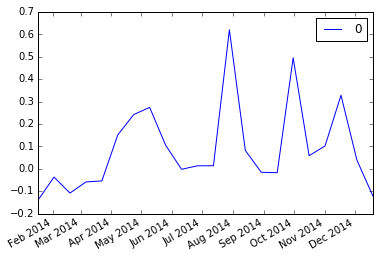

In [78]:
ts_reshape_mean = ts_reshape.mean(axis=0)
df_org = pd.DataFrame(ts_reshape_mean.flatten()/scaling_value,dates)
df_org.plot()

In [48]:
# compute HANTS
frequencies = np.round(len(ts_reshape_mean) * 16. / 365 * frequencies).astype(int)
frequencies
pyhants = HANTS(sample_count=time, inputs=ts_reshape, frequencies_considered_count=frequencies,  outliers_to_reject=outliers)
#pyhants = HANTS(time, ts_reshape/100, frequencies, outliers)
#pyhants *= 100
pyhants_mean = pyhants.mean(axis=0)
df = pd.DataFrame(pyhants_mean.flatten()/scaling_value,dates)
df_org = pd.DataFrame(ts_reshape_mean.flatten()/scaling_value,dates)

LinAlgError: Singular matrix

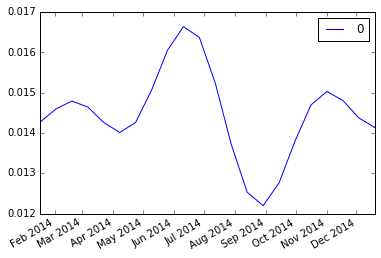

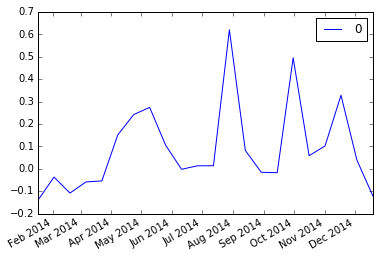

In [43]:
df.plot()
df_org.plot()

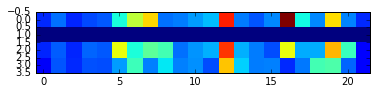

In [183]:
data = ts_reshape
plt.imshow(data, interpolation='nearest')


In [184]:
data[1] = -3000
mask = data == -3000
slice = np.invert(mask)[:,0].nonzero()[0]
print slice
data[slice]

[0 2 3]


array([[-1028.,  -203., -1091.,  -674.,  -474.,  1466.,  3846.,  5051.,
         -225.,   -86.,   312.,   642.,  7348.,   -64.,  -555.,    48.,
         8778.,  1393.,    56.,  4949.,     0., -1066.],
       [-1088.,  -428., -1105.,  -361.,  -473.,  4482.,  1515.,  2432.,
         2063.,  -233.,   192.,   530.,  7060.,   520.,   -73.,  -630.,
         4457.,   472.,   496.,  5454.,  1955., -1541.],
       [-1748.,  -537., -1056.,  -601.,  -633.,   275.,  2000.,   -52.,
         1150.,   -35.,   172.,  -641.,  5270.,   894.,   -84.,   -34.,
        -1055.,  -103.,  2083.,  2226.,  -359., -1640.]])

In [185]:
mask = data.mean(axis=-1) == -3000
slice = np.invert(mask).nonzero()[0]
slice

array([0, 2, 3], dtype=int64)

In [186]:
pyhants = HANTS(sample_count=time, inputs=data[slice]/100, frequencies_considered_count=frequencies,  outliers_to_reject=outliers)

In [187]:
out = np.empty_like(data)
out.fill(np.nan)

In [188]:
out[slice] = pyhants

In [189]:
out

array([[  83.03920391,   50.53165187,   11.89771176,  -10.99734535,
          -7.13959275,   16.50929623,   40.53102485,   47.22949294,
          33.45294849,   12.99542002,    6.79190807,   27.67799664,
          70.37332636,  113.84394969,  134.68898283,  122.54536715,
          87.00547901,   51.26292334,   36.73508009,   49.05947256,
          74.90312022,   91.62096776],
       [          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan],
       [ 120.60908224,   89.54117296,   51.42428593,   28.50481225,
          29.41454469,   44.6184423 ,   54.94824388,   46.78266467,
          22.84210926,    0.75868114,    0.30511752,   28.30888714,
          72.12116958,  106.70593211, 

In [205]:
percent = np.sum(data == -3000, axis=-1) / float(data.shape[1])
percent = percent >= 0.9

In [206]:
slice = np.invert(percent).nonzero()[0]
slice

array([0, 2, 3], dtype=int64)